In [1]:
import rebound
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state

/Users/rein/git/rebound/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
obs = observations.FakeObservation(planets=[{"m":1e-3, "a":1.}], Npoints=100, error=1e-4, tmax=10.)

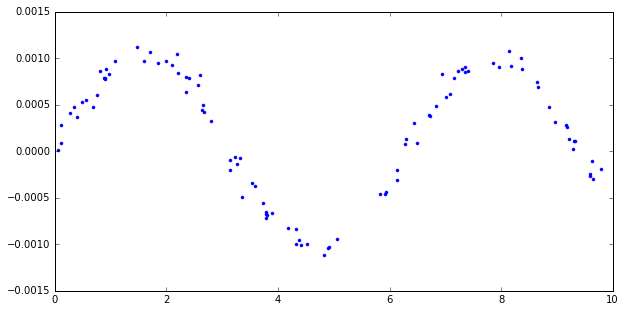

In [3]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(obs.t, obs.rv, ".")

In [4]:
true_state = state.State(planets=[{"m":1e-3, "a":1.}])

In [6]:
times, rv = true_state.get_rv_plotting()